# <center> Efficient detection of longitudinal bacteria fission using transfer learning in Deep Neural Networks
# <center> Supplemental Material

Most rod-shaped bacteria divide perpendicularly (along the narrow axis). Some, however, divide longitudinally (along the long axis). Few species are known to do so. Here we create a model of longitudinal divison that can help experimentalist researches to classify such images.

## Training code for longitudinal division classification

#### Requirements:
 * GPU
 * Nvidia driver
 * cuda version > 10
 * cython
 * opencv-python
 * tqdm
 * torchsummary
 * matplotlib
 * pandas
 * scipy
 * joblib
 * scikit-learn
 * jupyterlab
 * torch
 * torchvision
 * torchaudio
 * numpy

#### Folders
 * data: contains all image samples in the folders train, validation and test. 
 * model: where the trained model will be saved
 * fake_samples: fake bacteria images of longitudinal division to predict on unseen images.
 * samples: bacteria images to predict the class
 
#### train_functions_sgd.py code contains all functions that are called in the main function. Do not remove or delete this file.

Main code for training a pretrained resnet18 network to classify microscopy images of longitudinal division bacteria.

The code is based on transfer learning for computer vision. The original code can be [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

* runtraining() main function to perform the training of a binary classifier (0,1)
* data: Contains the folders train, val and test
* train, val, test: Are folders with image samples to train the model.
* model: Is the folder where the trained model will be save

========== How to run in terminal ==========

Copy and paste the code into a file called train_model.py, then run in a terminal:

`python train_model.py`

============================================

In [ ]:
from __future__ import print_function, division
import numpy as np
import torch
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn as nn
import train_functions_sgd as trnfn
import time
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import sys

### Function for making the training

In [ ]:
def runtraining():
    print('processing data')
    
    # data transformations to prepare the images for training
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    data_dir = 'data/'

    # image loader on batch of 16 images
    # Note if you get an error memory change to a batch of 8 or 4
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                      for x in ['train', 'val', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=8)
                      for x in ['train', 'val', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    
    # extract the classes label: 0 and 1
    class_names = image_datasets['train'].classes

    # setting up the device to train in CPU or GPU
    # if torch doesn't find a GPU available it will run on the CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'Device: {device} / Dataset_size: {dataset_sizes}')

    # prepare for training
    # setting a pretrained resnet18.
    # nn.Lienear(in_features, out_features): 
    # applies a linear transformation to the incoming data (features) to out features
    # the features are extracted from the pretrained resnet18 into 2 features. 
    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)
    model_ft = model_ft.to(device)

    # Setting up the type of loss function to optimize the model during training.
    criterion = nn.CrossEntropyLoss()

    # Setting up the optimizer function.
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    
    # training function
    # train_model:
    #             model_ft: defined model (Resnet18)
    #             criterion: cross entropy loss function
    #             optimizer_ft: optimization algorithm Stochastic Gradient Descent (SGD)
    #             exp_lr_scheduler: decay LR by a factor
    #             dataloaders: batch of images, 16 images per batch
    #             dataset_sizes: size of train and val samples
    #             device: GPU or CPU
    #             num_epochs: number of epochs to train in the data
    model_ft = trnfn.train_model(model_ft, criterion, optimizer_ft, 
                                 exp_lr_scheduler, dataloaders, 
                                 dataset_sizes, device, num_epochs=25)

    # Save model
    torch.save(model_ft.state_dict(), "model/trained_net_sgd_pre-25.pth")
  
    y_true, y_pred = trnfn.test_model(model_ft, criterion, device, dataloaders, dataset_sizes)
    y_pred = y_pred
    y_pred = y_pred

    print("accuracy score: ","%.6f" % accuracy_score(y_true, y_pred),"\n")
    print("confusion matrix:")
    print(confusion_matrix(y_true, y_pred),"\n")
    print("classification report:")
    print(classification_report(y_true, y_pred, digits=6))


### Running the training 

In [ ]:
""""
setting a random seed for reproducibility
however, Pytorch state:

"Completely reproducible results are not guaranteed across PyTorch releases, 
individual commits, or different platforms. Furthermore, results may not be 
reproducible between CPU and GPU executions, even when using identical seeds."

""""
np.random.seed(1234)

runtraining()

# Test the model

**Test the model with the test dataset**

* For the class 0 (longitudinal division) there are 741 images
* For the class 1 (other division) there are 4240 images

========== How to run in terminal ==========

Copy and paste the code into a file called test_model.py, then run in a terminal:

`python test_model.py`

============================================

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import torch.nn as nn
import train_functions_sgd as trnfn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Transform images into Tensors
# all images will be resize to a 128 x 128 (width,height)
# convert to tensors and normalize
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [5]:
# Load the data to test the model

data_dir = 'data/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=8) for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}

# Setting the device GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device} / Dataset_size: {dataset_sizes}')

Device: cpu / Dataset_size: {'test': 4981}


In [6]:
# Load model
criterion = nn.CrossEntropyLoss()
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

# Each output sample is set to 2.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.load_state_dict(torch.load("model/trained_net_sgd_pre-25.pth", map_location=map_location))
model_ft.to(device);


In [7]:
# Run predict on the test images
# depending on the hardware will be the time it takes to run the test
y_true, y_pred = trnfn.test_model(model_ft, criterion, device, dataloaders, dataset_sizes,'test')
y_pred = y_pred
y_pred = y_pred

acc_sc = accuracy_score(y_true, y_pred)

print("accuracy score: ","%.6f" % acc_sc,"\n")
print("confusion matrix:")
print(confusion_matrix(y_true, y_pred),"\n")
print("classification report:")
print(classification_report(y_true, y_pred, digits=6))

Test Loss: 0.0088
Test Acc: 0.9968
accuracy score:  0.996788 

confusion matrix:
[[ 735    6]
 [  10 4230]] 

classification report:
              precision    recall  f1-score   support

           0   0.986577  0.991903  0.989233       741
           1   0.998584  0.997642  0.998112      4240

    accuracy                       0.996788      4981
   macro avg   0.992580  0.994772  0.993673      4981
weighted avg   0.996797  0.996788  0.996791      4981



# Predict division type

**Predict on fake longitudinal division bacteria**

The prediction class must be other division (class 1)


========== How to run in terminal ==========

Copy and paste the code into a file called predict_class.py, then run in a terminal:

`python predict_class.py`

============================================

In [8]:
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
import os
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

In [9]:
# Reading content from folder "fake_samples"
# To test on unseen images during the training, we create 6 fake bacteria division

path = 'fake_samples/'
dirpath = os.path.dirname(os.path.realpath(path)) +"/"+path

# Read file names into array to load the images to predict their class
fake_samples_fn= []
with os.scandir(path) as it:
    for entry in it:
        if not entry.name.startswith('.') and entry.is_file():
            fake_samples_fn.append(entry.name)

In [10]:
# Transform images into Tensors
# all images will be resize to a 128 x 128 (width,height)
# convert to tensors and normalize
data_transforms = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


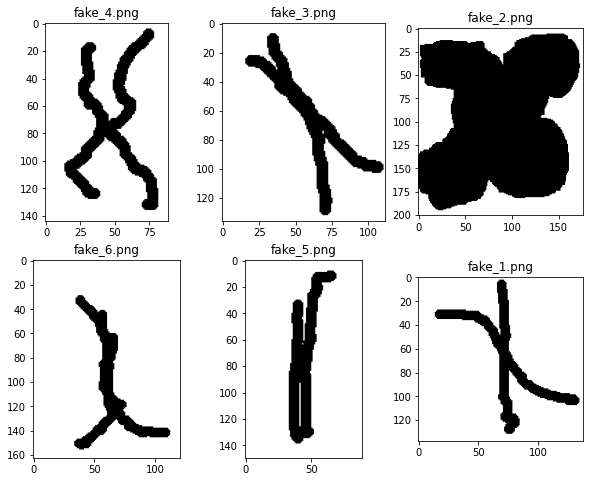

In [11]:
# Array of tensors
data_tensors=[]

# Show images to predict their class (fake images of bacteria)
fig = plt.figure(figsize=(10, 8))
for i in range(len(fake_samples_fn)):
    img = Image.open(dirpath+fake_samples_fn[i]).convert('RGB')
    data_tensors.append(data_transforms(img))
    plt.subplot(2,3,i+1).set_title(fake_samples_fn[i])
    plt.imshow(img)

In [12]:
# Predict the class of the fake images

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

# Load model
# Here the size of each output sample is set to 2.
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.load_state_dict(torch.load("model/trained_net_sgd_pre-25.pth", map_location=map_location))

dataloaders = DataLoader(data_tensors, batch_size=1, shuffle=False)

model_ft.eval()

i=0
for inputs in dataloaders:
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model_ft(inputs)
        # retrieve numpy array
        _, preds = torch.max(outputs, 1)
        preds = preds.detach().numpy()
        print('Predicted: class=%d file=%s' % (preds.round(), fake_samples_fn[i]))
    i += 1


Device: cpu
Predicted: class=1 file=fake_4.png
Predicted: class=1 file=fake_3.png
Predicted: class=1 file=fake_2.png
Predicted: class=1 file=fake_6.png
Predicted: class=0 file=fake_5.png
Predicted: class=1 file=fake_1.png


**Predict on unseen division bacteria**

The prediction class must be:

* longitudinal division (class 0)
* other division (class 1)

In [13]:
# Reading content from folder "samples"
# To test on unseen images during the training

path_samples = 'samples/'
dirpath = os.path.dirname(os.path.realpath(path_samples)) +"/"+path_samples

# Read file names into array to load the images to predict their class
samples_fn= []
with os.scandir(path_samples) as it:
    for entry in it:
        if not entry.name.startswith('.') and entry.is_file():
            samples_fn.append(entry.name)

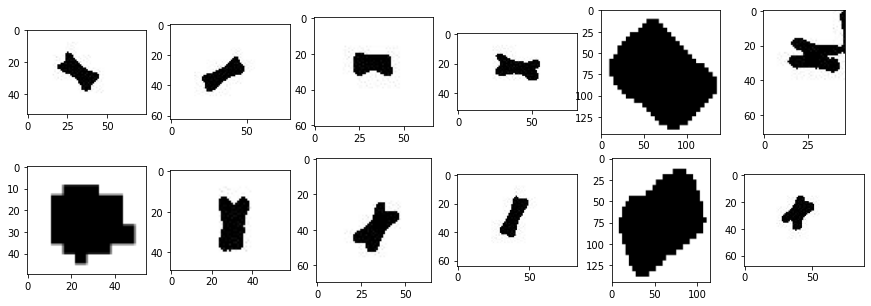

In [14]:
# Show the first 12 images of bacteria
fig = plt.figure(figsize=(15, 5))
for i in range(12):
    img = Image.open(dirpath+samples_fn[i]).convert('RGB')
    plt.subplot(2,6,i+1)
    plt.imshow(img)

In [15]:
# Array of tensors
data_tensors=[]

# add tensors to the data_tensors array to be predicted
for i in range(len(samples_fn)):
    img = Image.open(dirpath+samples_fn[i]).convert('RGB')
    data_tensors.append(data_transforms(img))

dataloaders = DataLoader(data_tensors, batch_size=1, shuffle=False)

model_ft.eval()

for i, inputs in enumerate(dataloaders):
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model_ft(inputs)
       # retrieve numpy array
        _, preds = torch.max(outputs, 1)
        preds = preds.detach().numpy()
        print('Predicted: class=%d file=%s' % (preds.round(), samples_fn[i]))


Predicted: class=0 file=longdiv_train_80.jpg
Predicted: class=0 file=longdiv_train_82.jpg
Predicted: class=0 file=longdiv_val_6.jpg
Predicted: class=0 file=longdiv_train_69.jpg
Predicted: class=1 file=Catasp1s_WGA_170228_004_bact_22561.png
Predicted: class=0 file=longdiv_train_20.jpg
Predicted: class=1 file=Catasp1s_WGA_170228_004_bact_27638.png
Predicted: class=0 file=longdiv_train_44.jpg
Predicted: class=0 file=longdiv_val_11.jpg
Predicted: class=0 file=longdiv_train_21.jpg
Predicted: class=1 file=Catasp1s_WGA_170228_004_bact_24261.png
Predicted: class=0 file=longdiv_train_10.jpg
Predicted: class=1 file=Catasp1s_WGA_170228_001_bact_72.png
Predicted: class=1 file=Catasp1s_WGA_170228_029_bact_2442.png
Predicted: class=0 file=longdiv_train_75.jpg
Predicted: class=0 file=Toneisti_oriC_1_161017_095_bact_3856.png
Predicted: class=0 file=longdiv_train_72.jpg
Predicted: class=1 file=Catasp1s_WGA_170228_013_bact_1962.png
Predicted: class=1 file=Catasp1s_WGA_170228_001_bact_30.png
Predicted: c